In [16]:
import pandas as pd
import numpy as np

# Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

# Garbage collector
import gc
gc.enable()

In [17]:
# Import the dataframes without JSON features and useless features
train_raw_df = pd.read_csv("cleaned_train_v2(2).csv",
    dtype={'date': str, 'fullVisitorId': str}, nrows=None)
test_raw_df = pd.read_csv("cleaned_test_v2(2).csv",
    dtype={'date': str, 'fullVisitorId': str}, nrows=None)
train_raw_df.shape, test_raw_df.shape

((1708337, 39), (401589, 39))

## First preprocessing

### NOTE: the next step is optional

### Inspect disguised nans

In [ ]:
# check how many categories are present per column (before nans substitution)
for c in train_raw_df.columns:
    print(c, len(np.unique(train_raw_df[c].astype(str))))

In [ ]:
from collections import Counter
Counter(train_raw_df['totals_sessionQualityDim'])

In [ ]:
"""

POSSIBLE DATA HANDLING

device_browser:
    'Safari (in-app)' -> 'Safari'
    'Opera Mini' -> 'Opera'
    'Mozilla' -> 'Firefox'
    'Mozilla Compatible Agent' -> 'Firefox'
"""

In [ ]:
train_raw_df['totals_timeOnSite'].unique()

### Convert disguised nans

In [18]:
nan_list = [
    "(not set)",
    "not available in demo dataset",
    "not.configured",
    "(not provided)",
    "unknown.unknown",
    "/",
    "(Other)",
    "(other)",
    "(none)",
    "nan",
    "[]"
]

nan_dict = {nl:np.nan for nl in nan_list}

# convert all "disguised" missing values to nans
def miss_to_nan(df):
    df.replace(nan_dict, inplace=True) # convert disguised NaNs
    df.dropna(axis=1, how='all', inplace=True)
    return df

In [19]:
# apply the preprocessing up to this point and save into copies
train_df = miss_to_nan(train_raw_df)
test_df = miss_to_nan(test_raw_df)

In [20]:
train_df.isnull().sum()

channelGrouping                                     137
customDimensions                                 333235
date                                                  0
fullVisitorId                                         0
visitId                                               0
visitNumber                                           0
visitStartTime                                        0
device_browser                                       12
device_deviceCategory                                 0
device_isMobile                                       0
device_operatingSystem                            11815
geoNetwork_city                                  998826
geoNetwork_continent                               2517
geoNetwork_country                                 2517
geoNetwork_metro                                1319855
geoNetwork_networkDomain                         769043
geoNetwork_region                                982733
geoNetwork_subContinent                         

### NOTE: the next step is optional

### Inspect data

In [ ]:
# check the nan condition in totals.newVisits
from itertools import compress
sum(list(compress(train_df['visitNumber'] > 1, train_df['totals.newVisits'].isnull()))) == train_df['totals.newVisits'].isnull().sum()

In [ ]:
# check the nan condition in totals.newVisits
print(sum(train_df['totals.newVisits'].isnull()))
sum(list(compress(train_df['totals.newVisits'].isnull(), train_df['visitNumber'] > 1)))

In [ ]:
# check if there is difference between nan and (none) in df['trafficSource.medium']
print(sum(train_df['trafficSource.medium'].isnull()))
sum(list(compress(train_df['trafficSource.medium'].isnull(), train_df['totals.transactionRevenue'] == 0)))

### c'è un valore con revenue !!!!!

In [ ]:
#same shit for trafficSource.source
print(sum(train_df['trafficSource.source'].isnull()))
sum(list(compress(train_df['trafficSource.source'].isnull(), train_df['totals.transactionRevenue'] == 0)))

In [ ]:
train_df.isnull().sum()

In [ ]:
#check again number of categories in each variable (eg column)
for c in train_df.columns:
    print(c, len(np.unique(train_df[c].astype(str))))

In [ ]:
for i in train_df.columns:    
    if len(train_df[i].unique()) <= 100:
        print(i + '\n')
        print(train_df[i].unique())
        print('\n')

## Second preprocessing

### NOTE: the next step is optional

In [21]:
train_df.columns

Index(['channelGrouping', 'customDimensions', 'date', 'fullVisitorId',
       'visitId', 'visitNumber', 'visitStartTime', 'device_browser',
       'device_deviceCategory', 'device_isMobile', 'device_operatingSystem',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_totalTransactionRevenue',
       'totals_transactionRevenue', 'totals_transactions',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
     

In [22]:
def train_test_distribution(col, dtype='float64'):
    """Plot a single numerical column distribution in linear and log scale."""
    fig, axis = plt.subplots(1, 2, figsize=(14,6))
    axis[0].set_title("Linear scale")
    axis[1].set_title("Log scale")
    
    train_df[col], test_df[col] = train_df[col].astype(dtype), test_df[col].astype(dtype)
    ax1 = sns.kdeplot(train_df[col].dropna(), label='train', ax=axis[0])
    ax2 = sns.kdeplot(test_df[col].dropna(), label='test', ax=axis[0])
    ax3 = sns.kdeplot(np.log(train_df[col].dropna()), label='train', ax=axis[1])
    ax4 = sns.kdeplot(np.log(test_df[col].dropna()), label='test', ax=axis[1])

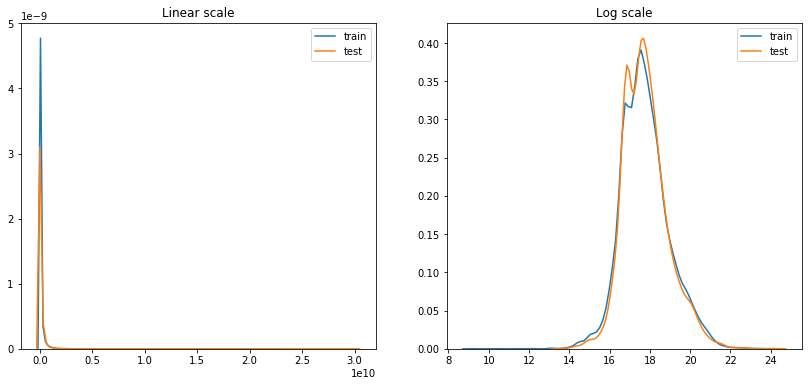

In [24]:
train_test_distribution('totals_transactionRevenue')

### Missing values filling

In [8]:
def fill_nans(df):
    
    
    df['channelGrouping'].fillna('Organic Search', inplace=True) # few nans, a lot of "Organic Search"
    df['device_browser'].fillna('Chrome', inplace=True) # few nans, a lot of "Chrome"
    df['device_operatingSystem'].fillna('unknown', inplace=True) # no predominance of any value, quite a bit of nans, keep separated category
    df['totals_pageviews'].fillna(1, inplace=True) # many 1s, nans do not bring any revenue -> nans become 1s
    df['trafficSource_medium'].fillna('unknown', inplace=True) # seems to be the same
    df['trafficSource_source'].fillna('unknown', inplace = True) # seems to be the same
    df['customDimensions'].fillna('unknown', inplace = True)
    
    
    df['geoNetwork_continent'].fillna('unknown', inplace=True)# keep separate category
    df['geoNetwork_country'].fillna('unknown', inplace=True)# keep separate category
    df['geoNetwork_subContinent'].fillna('unknown', inplace=True)# keep separate category

    # Targets
    df['totals_transactionRevenue'].fillna(0, inplace=True)
    df['totals_transactions'].fillna(0, inplace=True)
    df['totals_totalTransactionRevenue'].fillna(0, inplace=True)
    
    
    # Features with huge amout of nans
    df['totals_timeOnSite'].fillna(0, inplace=True) # to be decided together
    df['totals_sessionQualityDim'].fillna(0, inplace=True) # 1 means bad quality, and is the most frequent value. Anyway putting 0 may be significative
    df['geoNetwork_city'].fillna('unknown', inplace=True)
    df['geoNetwork_metro'].fillna('unknown', inplace=True)
    df['geoNetwork_networkDomain'].fillna('unknown', inplace=True)
    df['geoNetwork_region'].fillna('unknown', inplace=True)
    df['totals_bounces'].fillna(0, inplace=True) # nan and 1
    df['trafficSource_adContent'].fillna('unknown', inplace=True)
    df['trafficSource_adwordsClickInfo.adNetworkType'].fillna('unknown', inplace=True)
    df['trafficSource_adwordsClickInfo.gclId'].fillna('unknown', inplace=True)
    df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True) # nan and False
    df['trafficSource_adwordsClickInfo.page'].fillna(0, inplace=True) # 0 is not cointained in the set
    df['trafficSource_adwordsClickInfo.slot'].fillna('unknown', inplace=True)
    df['trafficSource_campaign'].fillna('unknown', inplace=True)
    df['trafficSource_isTrueDirect'].fillna(False, inplace=True) # nan and True
    df['trafficSource_keyword'].fillna('unknown', inplace=True)
    df['trafficSource_referralPath'].fillna('unknown', inplace=True)
    df['totals_newVisits'].fillna(0, inplace=True)# totals.newVisits is always == nan when visitNumber > 1, we keep it for now but it will be dropped eventually

    return df

In [9]:
train_df = fill_nans(train_df)
test_df = fill_nans(test_df)

In [10]:
train_df.isnull().sum()

channelGrouping                                 0
customDimensions                                0
fullVisitorId                                   0
visitId                                         0
visitNumber                                     0
visitStartTime                                  0
device_browser                                  0
device_deviceCategory                           0
device_isMobile                                 0
device_operatingSystem                          0
geoNetwork_city                                 0
geoNetwork_continent                            0
geoNetwork_country                              0
geoNetwork_metro                                0
geoNetwork_networkDomain                        0
geoNetwork_region                               0
geoNetwork_subContinent                         0
totals_bounces                                  0
totals_hits                                     0
totals_newVisits                                0


### Cast numerical features to float

In [ ]:
# float_features = ['visitId', 'visitNumber', 'visitStartTime', 'totals.bounces', 'totals.hits',
#                  'totals.newVisits', 'totals.pageviews', 'trafficSource.adwordsClickInfo.page',
#                  'trafficSource.isTrueDirect']

# for col in float_features:
#     train_df[col] = train_df[col].astype(float)
#     test_df[col] = test_df[col].astype(float)

### Cast string categorical features to lower case

In [11]:
string_features = ['channelGrouping', 'customDimensions', 'device_browser', 'device_deviceCategory',
                  'device_operatingSystem', 'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
                  'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region', 'geoNetwork_subContinent',
                  'trafficSource_adContent', 'trafficSource_adwordsClickInfo.adNetworkType', 'trafficSource_adwordsClickInfo.gclId',
                  'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign', 'trafficSource_referralPath',
                  'trafficSource_medium', 'trafficSource_source', 'trafficSource_keyword']

for col in string_features:
    train_df[col] = train_df[col].str.lower().astype(str)
    train_df[col] = train_df[col].astype(str)
    test_df[col] = test_df[col].str.lower().astype(str)
    test_df[col] = test_df[col].astype(str)

In [12]:
train_df.head()

,channelGrouping,customDimensions,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,...,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source
0,organic search,"[{'index': '4', 'value': 'emea'}]",3162355547410993243,1508198450,1,1508198450,firefox,desktop,False,windows,...,unknown,True,0.0,unknown,unknown,False,water bottle,organic,unknown,google
1,referral,"[{'index': '4', 'value': 'north america'}]",8934116514970143966,1508176307,6,1508176307,chrome,desktop,False,chrome os,...,unknown,True,0.0,unknown,unknown,False,unknown,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com
2,direct,"[{'index': '4', 'value': 'north america'}]",7992466427990357681,1508201613,1,1508201613,chrome,mobile,True,android,...,unknown,True,0.0,unknown,unknown,True,unknown,unknown,unknown,(direct)
3,organic search,"[{'index': '4', 'value': 'emea'}]",9075655783635761930,1508169851,1,1508169851,chrome,desktop,False,windows,...,unknown,True,0.0,unknown,unknown,False,unknown,organic,unknown,google
4,organic search,"[{'index': '4', 'value': 'central america'}]",6960673291025684308,1508190552,1,1508190552,chrome,desktop,False,windows,...,unknown,True,0.0,unknown,unknown,False,unknown,organic,unknown,google


### NOTE: the next step is optional (may improve performances but it has to be tested)

### Cleaning rare categories

In [ ]:
# Actually we have no longer missing values, and we can manage the problem of the rare categories
# We group them in an overfeature
def clear_rare_categories(df, feature, limit = 900):

    vc = df[feature].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), feature, "categories to 'other';", end=" ")
    
    df.loc[df[feature].map(lambda x: x not in common), feature] = 'other'
    print("now there are", df[feature].nunique(), "categories")
    
    return df

In [ ]:
# to be chacked better!!!

# There are features that we don't want to modify
raw_features = [
"channelGrouping",
"device.browser",
"device.deviceCategory",
"device.isMobile",
"device.operatingSystem",
"geoNetwork.city",
"geoNetwork.continent",
"geoNetwork.country",
"geoNetwork.metro",
"geoNetwork.networkDomain",
"geoNetwork.region",
"geoNetwork.subContinent",
"totals.bounces",
"totals.newVisits",
"trafficSource.adContent",
"trafficSource.adwordsClickInfo.adNetworkType",
# "trafficSource.adwordsClickInfo.isVideoAd",
"trafficSource.adwordsClickInfo.slot",
"trafficSource.campaign",
"trafficSource.isTrueDirect",
"trafficSource.keyword",
"trafficSource.medium",
"trafficSource.referralPath",
"trafficSource.source"
]


for feat in raw_features:
    print("\nTRAIN:\n")
    train_df = clear_rare_categories(train_df, feat)
    print("\nTEST:\n")
    test_df = clear_rare_categories(test_df, feat)
    
#     if(train_df[feat].nunique() != test_df[feat].nunique()):
#         print("\n\n\nWARNING:\n")


In [ ]:
for i in train_df.columns:    
    if len(train_df[i].unique()) <= 100:
        print(i + '\n')
        print(train_df[i].unique())
        print('\n')

In [ ]:
#check again number of categories in each variable (eg column)
for c in train_df.columns:
    print(c, len(np.unique(train_df[c].astype(str))))

### Drop meaningless columns

In [13]:
meaningless_columns =[]

def drop_meaningless_columns(df, meaningless_columns):
    df.drop(meaningless_columns, axis=1, inplace=True)
    return df

train_df = drop_meaningless_columns(train_df, meaningless_columns)
test_df = drop_meaningless_columns(test_df, meaningless_columns)
train_df.shape, test_df.shape

((1708337, 38), (401589, 38))

In [ ]:
"""

meaningless_columns = [
    'geoNetwork.city', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
    'totals.bounces',
    'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId',
    'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot',
    'trafficSource.campaign', 'trafficSource.isTrueDirect', 'trafficSource.keyword', 'trafficSource.referralPath'   
]

#NO DROP VERSION
for i in meaningless_columns:
    if train_df[i].dtype == float:

        train_df[i].fillna(0, inplace=True)
        test_df[i].fillna(0, inplace=True)
    else:
        print(i)        
        train_df[i].fillna('(other)', inplace=True)
        test_df[i].fillna('(other)', inplace=True)    

def drop_meaningless_columns(df, meaningless_columns):
    df.drop(meaningless_columns, axis=1, inplace=True)
    return df

#train_df = drop_meaningless_columns(train_df, meaningless_columns)
#test_df = drop_meaningless_columns(test_df, meaningless_columns)
train_df.shape, test_df.shape

"""

### NOTE: the next step is optional

###  Label encoder

In [ ]:
from sklearn import preprocessing

for col in string_features:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

### Export Dataframes

In [14]:
train_df.to_csv('preprocessed_train_v2(3).csv', index = False)
test_df.to_csv('preprocessed_test_v2(3).csv', index = False)